In [1]:
import numpy as np
import itkwidgets
import itk
import nibabel as nib
import ipywidgets as widgets
from skimage.measure import label
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def read_im_gt(img_path, gt_path, organ_label = None):
    img, gt = nib.load(img_path), nib.load(gt_path)
    img_ras, gt_ras = img, gt  # Initialize variables to hold potentially reoriented images

    # Check if gt, image are already in RAS+ 
    if nib.aff2axcodes(img.affine) != ('R', 'A', 'S'):
        img_ras = nib.as_closest_canonical(img)

    if nib.aff2axcodes(gt.affine) != ('R', 'A', 'S'):
        gt_ras = nib.as_closest_canonical(gt)

    img_data = img_ras.get_fdata().astype(np.float32)
    gt_data = gt_ras.get_fdata().astype(int)

    # Ensure organ is binary
    if organ_label is None:
        flat_data = gt_data.ravel()
        if not np.all( (flat_data == 0) | (flat_data == 1)):
            raise RuntimeError('Ground truth is not binary and no foreground label to subset to is specified')
        
    else:
        gt_data = (gt_data == organ_label).astype(int)

    img_data, gt_data = img_data.transpose(2,1,0), gt_data.transpose(2,1,0) # change from RAS to row-major ie xyz to zyx
    
    return(img_data, gt_data)

def get_nearest_fg_point(point, binary_mask):
    """
    Find the nearest foreground coordinate (value 1) to the given 2D point in a binary mask.

    Parameters:
    point (tuple): The (y, x) coordinates of the point.
    binary_mask (numpy.ndarray): The 2D binary mask.

    Returns:
    tuple: The (y, x) coordinates of the nearest foreground point.
    """
    # Get the indices of the foreground pixels
    fg_coords = np.column_stack(np.where(binary_mask == 1))
    
    # Create a KD-tree from the foreground coordinates
    tree = cKDTree(fg_coords)
    
    # Query the nearest single neighbor
    distance, index = tree.query([point], k=1)
    nearest_fg_point = fg_coords[index[0]]

    return tuple(nearest_fg_point)
  
def get_bbox(mask):
    i_any = np.any(mask, axis=1)
    j_any = np.any(mask, axis=0)
    i_min, i_max = np.where(i_any)[0][[0, -1]]
    j_min, j_max = np.where(j_any)[0][[0, -1]]
    bb_min = np.array([i_min, j_min])
    bb_max = np.array([i_max, j_max])

    return bb_min, bb_max
    
def get_largest_CC(segmentation):
    labels = label(segmentation)
    assert( labels.max() != 0 ) # assume at least 1 CC
    largestCC = labels == np.argmax(np.bincount(labels.flat)[1:])+1
    return largestCC.astype(int)

def interpolate_points(points, kind='linear'):
    """
    Interpolate points in 3D space using linear or cubic spline interpolation.

    Parameters:
    points (numpy.ndarray): An array of shape (n, 3) where each row represents (z, y, x).
    kind (str): Type of interpolation, either 'linear' or 'cubic'.

    Returns:
    numpy.ndarray: Array of interpolated points at each integer z-coordinate within the range of input z-coordinates.
    """
    # Ensure points are sorted by z-coordinate
    points = points[points[:, 0].argsort()]

    # Separate z, y, and x coordinates
    z, y, x = points[:, 0], points[:, 1], points[:, 2]

    # Create interpolation functions for y and x as functions of z
    y_interp = interp1d(z, y, kind=kind)
    x_interp = interp1d(z, x, kind=kind)

    # Create an array of z values for which we want to interpolate y and x
    z_new = np.arange(z.min(), z.max() + 1)
    y_new = y_interp(z_new)
    x_new = x_interp(z_new)

    # Stack the new z, y, and x coordinates vertically and return
    return np.column_stack((z_new, y_new, x_new)).round()

def get_fg_points_from_cc_centers(gt, n):
    '''
    Takes n equally spaced slices starting at z_min and ending at z_max, where z_min is the lowest transverse slice of gt containing fg, and z_max similarly with highest, 
    finds the largest connected component of fg, takes the center of its bounding box and takes the nearest fg point. Simulates a clinician clicking in the 'center of the main mass of the roi' per slice
    '''
    z_indices = np.where(np.any(gt, axis = (1,2)))[0]
    min_z, max_z = np.min(z_indices), np.max(z_indices)
    selected_slices = np.linspace(min_z, max_z, num=n, dtype=int)
    sampled_points = np.empty([n, 3], dtype = int)
    corrected_points = np.empty([n, 3], dtype = int)
    for i, z in enumerate(selected_slices): #selected_slices:
        largest_cc = get_largest_CC(gt[z])
        bbox_min, bbox_max = get_bbox(largest_cc)
        slice_fg_center = np.vstack([bbox_min, bbox_max]).mean(axis=0).round()
        sampled_points[i] = np.concatenate([[z], slice_fg_center])
        nearest_fg_point = get_nearest_fg_point(slice_fg_center, largest_cc)
        corrected_points[i] = np.concatenate([[z], nearest_fg_point])    

    return(corrected_points)

def show_slices(volume, start_z, n_slice, n_row, points=None, points2 = None):
    """
    Display rows of transverse slice plots from a 3D volume and plot points that fall on the slices.

    Parameters:
    volume (numpy.ndarray): The 3D volume from which to extract and display slices.
    start_z (int): The starting z index for the slices to be displayed.
    n_slice (int): The total number of slices to display.
    n_row (int): The number of rows to display the slices in.
    points (iterable of triples): An iterable of (z, y, x) points to be plotted.
    """
    # Calculate the number of columns per row
    n_col = -(-n_slice // n_row)  # Ceiling division to get columns

    fig, axes = plt.subplots(n_row, n_col, figsize=(n_col*3, n_row*3), squeeze=False)
    for i in range(n_slice):
        row, col = divmod(i, n_col)
        ax = axes[row, col]
        slice_idx = start_z + i
        if slice_idx < volume.shape[0]:  # Check if the index is within the bounds of the volume
            ax.imshow(volume[slice_idx], cmap='gray', origin='lower')
            # Plot points if they are on the current slice
            if points is not None:
                for point in points:
                    if point[0] == slice_idx:
                        # Point coordinates must be shifted to match image display orientation
                        ax.scatter(point[2], point[1], color='red', s=35)  # x, y coordinates are switched for plotting
            if points2 is not None:
                for point in points2:
                    if point[0] == slice_idx:
                        # Point coordinates must be shifted to match image display orientation
                        ax.scatter(point[2], point[1], color='blue', s=25)  # x, y coordinates are switched for plotting
            ax.set_title(f'Slice {slice_idx}')
        else:
            ax.imshow(np.zeros_like(volume[0]), cmap='gray', origin='lower')
            ax.set_title('No Slice')
    
    # Hide any unused subplots if n_slice is not perfectly divisible by n_row
    for j in range(i+1, n_row*n_col):
        row, col = divmod(j, n_col)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()


# Load in image, label, prompt
img_path = '/home/t722s/Desktop/Datasets/BratsMini/imagesTs/BraTS2021_01646.nii.gz'
gt_path = '/home/t722s/Desktop/Datasets/BratsMini/labelsTs/BraTS2021_01646.nii.gz'

img, gt = read_im_gt(img_path, gt_path)
n = 5



In [2]:
interp_points = interpolate_points(get_fg_points_from_cc_centers(gt, 5))
centers = get_fg_points_from_cc_centers(gt, 48)

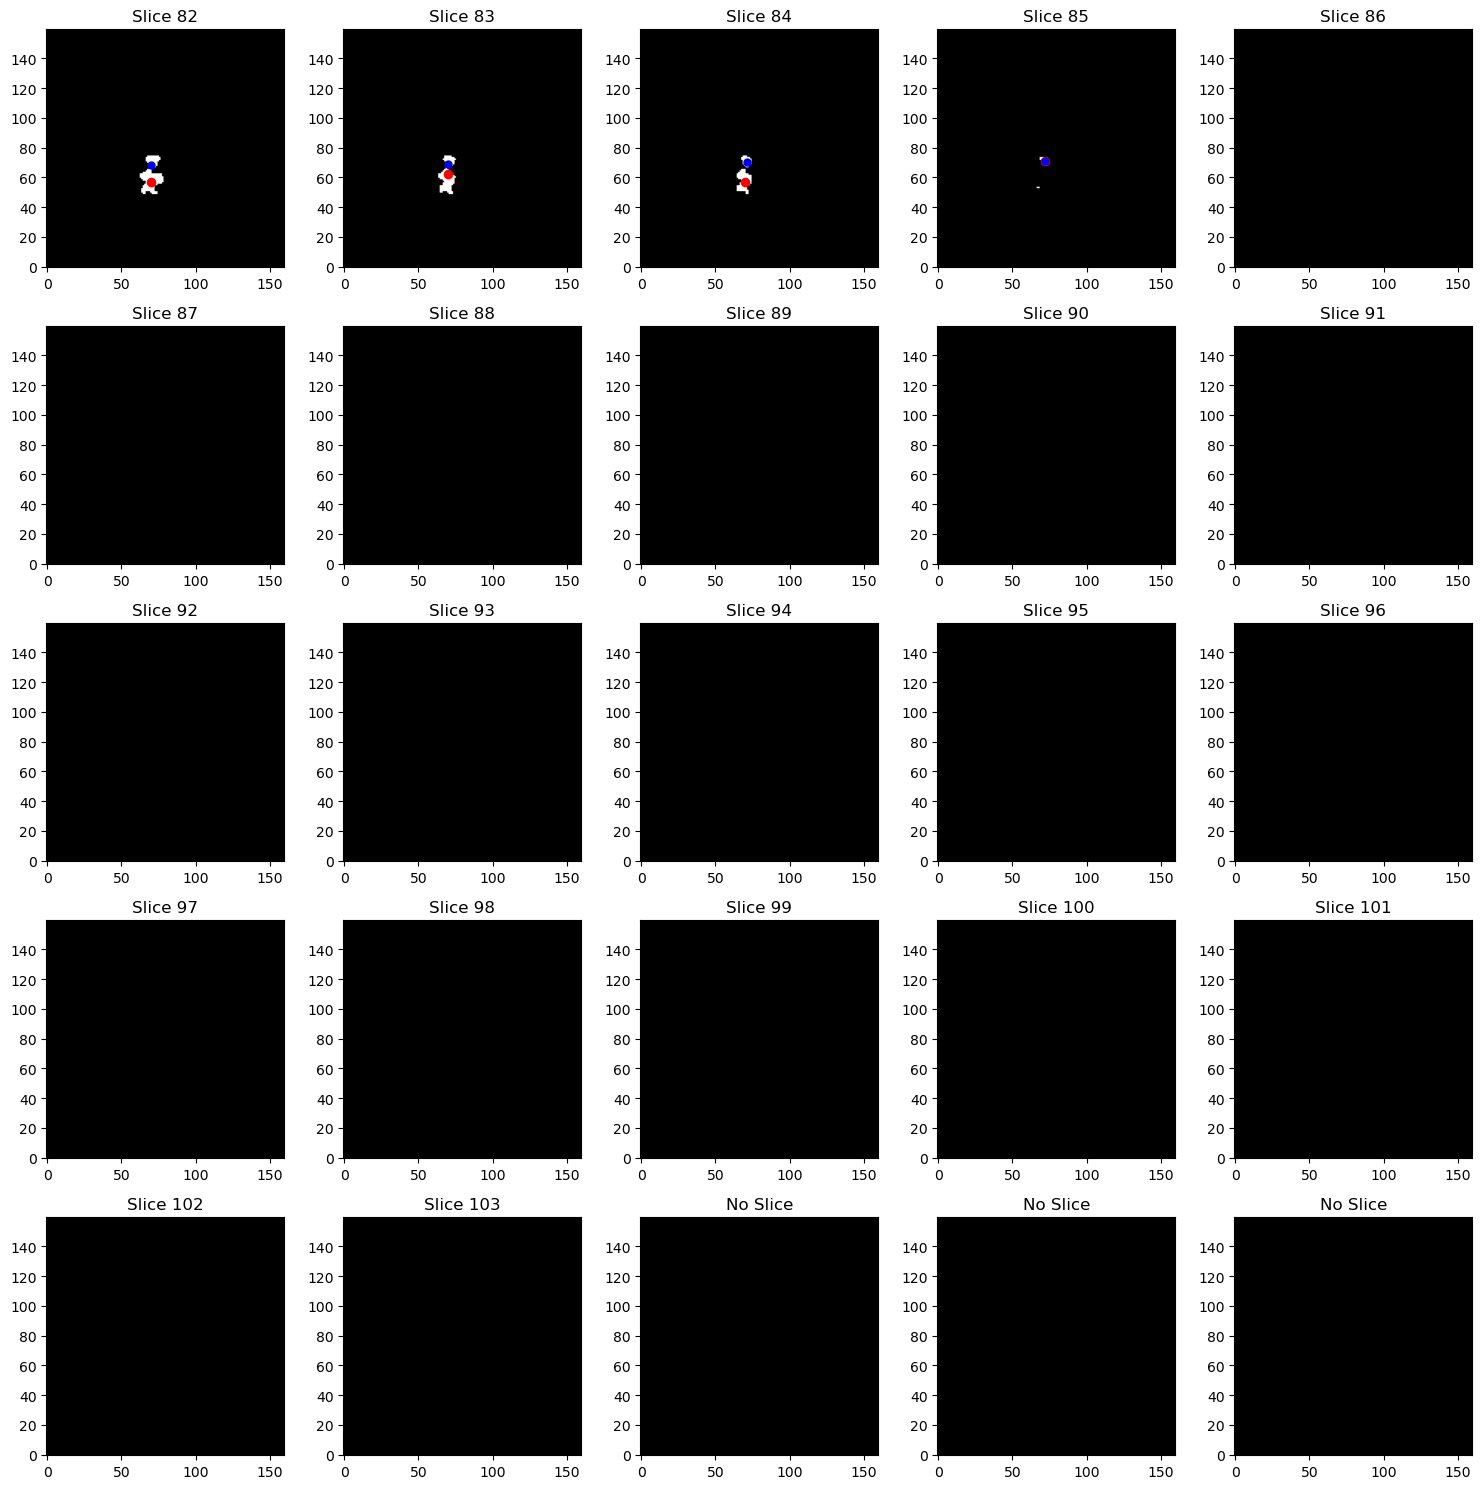

In [5]:


show_slices(gt, start_z=82, n_slice=25, n_row = 5, points = centers, points2 = interp_points)
